In [1]:
import sys
import os
import math
import random
import heapq 
import time
import datetime
import copy
import gc
import numpy as np
import pandas as pd
import threading
import csv
from functools import reduce
from sklearn.model_selection import train_test_split
from scipy.spatial.distance import pdist
from sklearn.metrics import confusion_matrix,roc_curve,accuracy_score,auc 
from PIL import Image
import matplotlib.pyplot as plt
from matplotlib.pylab import date2num
import cv2
import faiss 
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models
import baostock as bs#pip install baostock
import mplfinance as mpf #pip install mplfinance
import easyquotation #pip install easyquotation
import tushare as ts # pip install tushare
tstoken='2621bdfffbde695d0d256a69a71d9344c94c1d8a58f389cd391ceeeb' #youer token
ts.set_token(tstoken)
pro = ts.pro_api()
print(pro)
torch.cuda.set_device(7)
print (torch.cuda.current_device())

Loading faiss with AVX2 support.


7


1.Training model and output database(faiss)

In [2]:
#define model: ATH
class SpatialAttention(nn.Module):#spatial attention layer
    def __init__(self):
        super(SpatialAttention, self).__init__()

        self.conv1 = nn.Conv2d(2, 1, kernel_size=3, padding=1, bias=False)
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, x):
        avg_out = torch.mean(x, dim=1, keepdim=True)
        max_out, _ = torch.max(x, dim=1, keepdim=True)
        x = torch.cat([avg_out, max_out], dim=1)
        x = self.conv1(x)
        return self.sigmoid(x)
    
class ResBlock(nn.Module):
    def __init__(self, in_channels: int, out_channels: int, stride=1):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(
                in_channels=in_channels, out_channels=out_channels,
                kernel_size=3, stride=stride, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, 3, 1, 1, bias=False),
            nn.BatchNorm2d(out_channels),
        )

        self.downsample_layer = None
        self.do_downsample = False
        if in_channels != out_channels or stride != 1:
            self.do_downsample = True
            self.downsample_layer = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, 3, stride, 1, bias=False),
                nn.BatchNorm2d(out_channels),
            )

        # initialize weights
        self.apply(self.init_weights)

    def forward(self, x):
        identity = x
        out = self.net(x)

        if self.do_downsample:
            identity = self.downsample_layer(x)

        return F.relu(out + identity, inplace=True) #resnet

    @staticmethod
    def init_weights(m):
        if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
            nn.init.xavier_normal_(m.weight)
            
class ATHNet(nn.Module):
    def __init__(self, code_size: int):
        super().__init__()
        #resnet and maxpool
        self.net1 = nn.Sequential(#(3,256,256)->(16,128,128)
            ResBlock(in_channels=3, out_channels=16, stride=2), 
            nn.MaxPool2d(kernel_size=3, padding=1, stride=1)
        )
        
        #Attention (16,128,128)->(16,128,128)
        self.sa = SpatialAttention()
        
        #resnet and meanpool
        self.net2 =nn.Sequential( #(16,128,128)->(8,64,64)
            ResBlock(in_channels=16, out_channels=8, stride=2),
            nn.AvgPool2d(kernel_size=3, padding=1, stride=1)
        ) 
         
        #fully connected with conv (8,64,64)->(1,32,32)
        self.dense=ResBlock(in_channels=8, out_channels=1, stride=2)
        #fully connected (1,32,32)->class_size
        self.linear = nn.Linear(1*32*32, code_size)
    
        # initialize weights
        self.apply(self.init_weights)

    def forward(self, x):
        x = self.net1(x)
        x = self.sa(x)*x
        x = self.net2(x)
        x = self.dense(x)
        x = x.view(x.size(0),-1)
        x = self.linear(x)
        return x

    @staticmethod
    def init_weights(m):
        if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
            nn.init.xavier_normal_(m.weight)

#define loss function:pairwise loss            
class PairwiseLoss(nn.Module):
    def __init__(self, margin=0.5, alpha=0.01):
        super(PairwiseLoss, self).__init__()
        self.alpha = alpha #regularization
        self.margin = margin #margin threshold
        self.mse_loss = nn.MSELoss(reduction='none')
        self.l1_loss = nn.L1Loss(reduction='mean')
    
    def forward(self,h1,h2,y):    
        margin_val = self.margin * h1.shape[1]
        squared_loss = torch.mean(self.mse_loss(h1, h2), dim=1)
        # T1: 0.5 * (1 - y) * dist(x1, x2)
        positive_pair_loss = (0.5 * (1 - y) * squared_loss)
        mean_positive_pair_loss = torch.mean(positive_pair_loss)
        # T2: 0.5 * y * max(margin - dist(x1, x2), 0)
        zeros = torch.zeros_like(squared_loss)
        marginMat = margin_val * torch.ones_like(squared_loss)
        negative_pair_loss = 0.5 * y * torch.max(zeros, marginMat - squared_loss)
        mean_negative_pair_loss = torch.mean(negative_pair_loss)

        # T3: alpha(dst_l1(abs(x1), 1)) + dist_l1(abs(x2), 1)))
        mean_value_regularization = self.alpha * (
                self.l1_loss(torch.abs(h1), torch.ones_like(h1)) +
                self.l1_loss(torch.abs(h2), torch.ones_like(h2)))

        loss = mean_positive_pair_loss + mean_negative_pair_loss + mean_value_regularization
        return loss

In [5]:
#Generate Dataset
root_dir = '/data/fjsdata/qtsys/img/' #the path of images
data = pd.read_csv('/data/fjsdata/qtsys/label.csv') 
data = data.drop_duplicates()
data = data.sample(frac=1).reset_index(drop=True) #shuffle
#Dataset
trN,trI, trY =[], [],[]
for _, row in data.iterrows():
    try:
        image_path = os.path.join(root_dir, row['name'])
        img = cv2.resize(cv2.imread(image_path).astype(np.float32), (256, 256))#(1600,800,3)->(256,256,3)
        trN.append(row['name'])
        trI.append(img)
        if row['label']=='B':
            trY.append(0) #buy
        else:# row['label']=='S':
            trY.append(1) #sell
    except:
        print(iname+":"+str(image_path))
    sys.stdout.write('\r{} / {} '.format(len(trY),data.shape[0]))
    sys.stdout.flush()
    
#Generate image pairs for model
def onlineGenImgPairs():
    if (len(trY) % 2) == 0: spls = len(trY)
    else:  spls = len(trY)-1
    idx_sf = random.sample(range(0, spls),spls)
    trI1_sf, trI2_sf, trY1_sf, trY2_sf = [],[],[],[]
    flag = 0
    for i in idx_sf:
        if flag==0:
            trI1_sf.append(trI[i])
            trY1_sf.append(trY[i])
            flag =1
        else:
            trI2_sf.append(trI[i])
            trY2_sf.append(trY[i])
            flag =0
    trY_sf = np.where((np.array(trY1_sf)-np.array(trY2_sf))!=0,1,0)
    return np.array(trI1_sf),np.array(trI2_sf),trY_sf

#define model
model = ATHNet(code_size=36).cuda()
criterion  = PairwiseLoss(margin=0.5).cuda() #define loss function
optimizer = torch.optim.Adam(model.parameters(), lr=0.001) #define optimizer
#train model
best_net, best_loss = None, float('inf')
batchSize = 10
for epoch in range(10):#iteration
    trI1_sf, trI2_sf, trY_sf = onlineGenImgPairs()
    losses = []
    num_batches = len(trY_sf) // batchSize +1
    for i in range(num_batches):
        optimizer.zero_grad()#grad vanish
        min_idx = i * batchSize
        max_idx = np.min([len(trY_sf), (i+1)*batchSize])
        I1_batch = torch.from_numpy(trI1_sf[min_idx:max_idx]).type(torch.FloatTensor).cuda()
        I2_batch = torch.from_numpy(trI2_sf[min_idx:max_idx]).type(torch.FloatTensor).cuda()
        Y_batch = torch.from_numpy(trY_sf[min_idx:max_idx]).type(torch.FloatTensor).cuda()
        #forword
        X1_batch = model(I1_batch.permute(0, 3, 1, 2))#permute the dims of matrix
        X2_batch = model(I2_batch.permute(0, 3, 1, 2))
        #binary-like loss
        loss = criterion(X1_batch,X2_batch,Y_batch)
        #backward
        loss.backward()
        #update parameters
        optimizer.step()
        #show loss
        sys.stdout.write('\r {} / {} : loss = {}'.format(i+1, num_batches, float('%0.6f'%loss.item())))
        sys.stdout.flush()     
        losses.append(loss.item())
    print("Eopch: %5d mean_loss = %.6f" % (epoch + 1, np.mean(losses)))
    if np.mean(losses) < best_loss:
        best_loss = np.mean(losses)
        best_net = copy.deepcopy(model)
print("best_loss = %.6f" % (best_loss))

#release gpu memory
model = model.cpu()
loss=loss.cpu()
torch.cuda.empty_cache()
#output the feature with best model
#torch.cuda.synchronize()
batchSize = 10
if (len(trY) % 10) == 0: num_batches = len(trI) // batchSize
else:  num_batches = len(trI) // batchSize +1
trF = []
for i in range(num_batches):
    min_idx = i * batchSize
    max_idx = np.min([len(trI), (i+1)*batchSize])
    I_batch = torch.from_numpy(np.array(trI[min_idx: max_idx])).type(torch.FloatTensor).cuda()
    X_batch = best_net(I_batch.permute(0, 3, 1, 2))#forword
    X_batch = torch.tanh(X_batch) #[-1,1]
    I_batch = I_batch.cpu()
    X_batch = X_batch.cpu()
    torch.cuda.empty_cache()#release gpu memory
    trF.extend(X_batch.data.numpy().tolist())
    sys.stdout.write('\r {} / {} '.format(i, num_batches))
    sys.stdout.flush()
    
# buliding index for retrieval
tstart = time.time()
cpu_index = faiss.IndexFlatL2(36) #
gpu_index = faiss.index_cpu_to_all_gpus(cpu_index) #make all gpu usable
gpu_index.add(np.ascontiguousarray(trF, dtype=np.float32)) #add data(must be float32) to index
elapsed = time.time() - tstart    
print('Completed buliding index in %d seconds' % int(elapsed))

 41 / 41 : loss = 0.040123Eopch:     1 mean_loss = 2.082743
 41 / 41 : loss = 0.404038Eopch:     2 mean_loss = 0.836552
 41 / 41 : loss = 0.301475Eopch:     3 mean_loss = 0.598625
 41 / 41 : loss = 0.049383Eopch:     4 mean_loss = 0.466227
 41 / 41 : loss = 0.565183Eopch:     5 mean_loss = 0.431148
 41 / 41 : loss = 0.199407Eopch:     6 mean_loss = 0.414506
 41 / 41 : loss = 2.423135Eopch:     7 mean_loss = 0.420428
 41 / 41 : loss = 0.074512Eopch:     8 mean_loss = 0.344636
 41 / 41 : loss = 0.391381Eopch:     9 mean_loss = 0.317795
 41 / 41 : loss = 0.848513Eopch:    10 mean_loss = 0.337271
best_loss = 0.317795
 80 / 81 Completed buliding index in 23 seconds


2. Online Generate Kline picture and predict whether buy or not 

login success!
Codes: 3751 have been collected


Exception in thread Thread-4:
Traceback (most recent call last):
  File "/root/miniconda3/lib/python3.7/threading.py", line 926, in _bootstrap_inner
    self.run()
  File "/root/miniconda3/lib/python3.7/threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-7-8ac09089a801>", line 85, in plot_predict_thread
    teI = best_net(teI.permute(0, 3, 1, 2))#forword
  File "/root/miniconda3/lib/python3.7/site-packages/torch/nn/modules/module.py", line 493, in __call__
    result = self.forward(*input, **kwargs)
  File "<ipython-input-2-c415e9764b62>", line 82, in forward
    x = self.net1(x)
  File "/root/miniconda3/lib/python3.7/site-packages/torch/nn/modules/module.py", line 493, in __call__
    result = self.forward(*input, **kwargs)
  File "/root/miniconda3/lib/python3.7/site-packages/torch/nn/modules/container.py", line 92, in forward
    input = module(input)
  File "/root/miniconda3/lib/python3.7/site-packages/torch/nn/modules/module.py", lin

KeyboardInterrupt: 

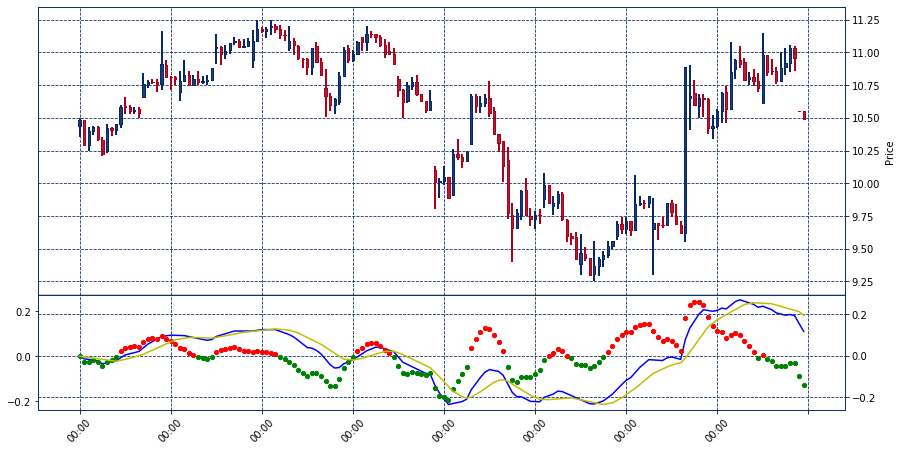

Exception in thread Thread-30014:
Traceback (most recent call last):
  File "/root/miniconda3/lib/python3.7/threading.py", line 926, in _bootstrap_inner
    self.run()
  File "/root/miniconda3/lib/python3.7/threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-7-8ac09089a801>", line 78, in plot_predict_thread
    mpf.plot(df_kline,**kwargs,addplot=apds,style='sas',savefig=save)#charles
  File "/root/miniconda3/lib/python3.7/site-packages/mplfinance/plotting.py", line 35, in decorator
    return func(*args, **kwargs)
  File "/root/miniconda3/lib/python3.7/site-packages/mplfinance/plotting.py", line 212, in plot
    ax3 = ax1.twinx()
  File "/root/miniconda3/lib/python3.7/site-packages/matplotlib/axes/_base.py", line 4437, in twinx
    ax2 = self._make_twin_axes(sharex=self)
  File "/root/miniconda3/lib/python3.7/site-packages/matplotlib/axes/_base.py", line 4414, in _make_twin_axes
    self._twinned_axes.join(self, ax2)
  File "/root/minico

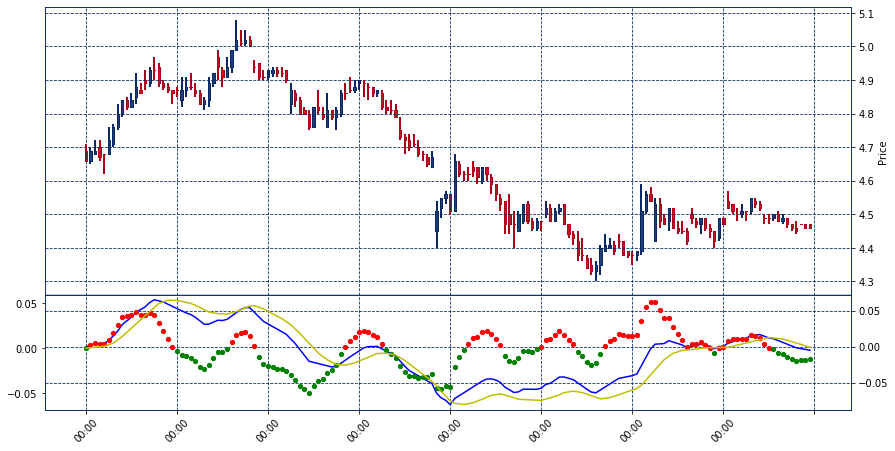

In [7]:
#Calculate MACD
def cal_macd_system(data,short_,long_,m):
    '''
    data=['Open','High','Low','Close']
    parameter: short_,long_,m
    return:data=['Open','High','Low','Close','diff','dea','macd']
    '''
    data['diff']=data['Close'].ewm(adjust=False,alpha=2/(short_+1),ignore_na=True).mean()-\
                data['Close'].ewm(adjust=False,alpha=2/(long_+1),ignore_na=True).mean()
    data['dea']=data['diff'].ewm(adjust=False,alpha=2/(m+1),ignore_na=True).mean()
    data['macd']=2*(data['diff']-data['dea'])
    return data
def macd_zero(macd):
    pos_signal, neg_signal = [],[]
    for idx,value in macd.iteritems():
        if value > 0:
            pos_signal.append(value)
            neg_signal.append(np.nan)
        else:
            neg_signal.append(value)
            pos_signal.append(np.nan)
    return pos_signal,neg_signal

#http://tushare.org/trading.html               
#https://tushare.pro/document/2
def his_kline():
    #read stocks information
    df_stocks = pro.stock_basic(exchange='', list_status='L', fields='symbol')
    #read k data
    today  = (datetime.datetime.now()+datetime.timedelta(hours=8)).strftime('%Y%m%d')#UTC->CTS +8hours
    df_cal = pro.trade_cal(exchange='', start_date='20200101', end_date=today)
    df_cal =df_cal[df_cal['is_open']==1].reset_index(drop=True)
    edate = df_cal[-21:][-1:]['cal_date'].tolist()[0] #last-1
    sdate = df_cal[-21:].head(1)['cal_date'].tolist()[0] #first
    edate = datetime.datetime.strptime(edate, '%Y%m%d').strftime('%Y-%m-%d') #turn to datetime
    sdate = datetime.datetime.strptime(sdate, '%Y%m%d').strftime('%Y-%m-%d')  #turn to datetime
    fields= "Open,High,Low,Close"
    All_His_KLine = {}
    for code in df_stocks['symbol'].tolist():
        if code[0]=='6': bs_code = 'sh.'+ code
        elif code[0]=='0' or code[0]=='3': bs_code = 'sz.'+ code
        else: continue
        #read transaction data
        rs = bs.query_history_k_data(code=bs_code, fields=fields, \
                                    start_date=sdate, end_date=edate, \
                                    frequency="30",adjustflag="3") #40days，one k line per 60 minutes
        data_list = []
        while (rs.error_code == '0') & rs.next():
            data_list.append(rs.get_row_data())
        result = pd.DataFrame(data_list, columns=rs.fields)
        result=result.apply(pd.to_numeric, errors='ignore')
        if result.shape[0] ==160:
            All_His_KLine[code]=result
    return All_His_KLine,today

def plot_predict_thread(best_net,All_His_KLine,All_Now_KLine,today):
    for code in list(All_His_KLine.keys()):
        his_kline = All_His_KLine[code] #dataframe
        if code in list(All_Now_KLine.keys()): #not open,
            price_list = All_Now_KLine[code]
            his_kline.loc[his_kline.shape[0]]={'Open':price_list[0],'High':np.array(price_list).max(),\
                                                'Low':np.array(price_list).min(),'Close':price_list[-1]}
        df_kline = his_kline[-160:].reset_index(drop=True) #get last 160
        #plot
        df_kline.index=pd.to_datetime(df_kline.index)#turn index to datatime
        df_kline = cal_macd_system(df_kline,12,26,9)
        pos_macd, neg_macd  = macd_zero(df_kline['macd']) 
        apds = [ mpf.make_addplot(df_kline['diff'],panel='lower',color='b'),
                     mpf.make_addplot(df_kline['dea'],panel='lower',color='y'),
                     mpf.make_addplot(pos_macd,panel='lower',color='r',scatter=True),
                     mpf.make_addplot(neg_macd,panel='lower',color='g',scatter=True)
                    ]
        kwargs = dict(type='candle',figratio =(16,8),volume=False,figscale=1)#line，mav=(5,10)
        now_time  = (datetime.datetime.now()+datetime.timedelta(hours=8)).strftime('%H:%M:%S')#UTC->CTS +8hours
        file_name = code+'-'+today+'-'+now_time+'.png'
        Kline_path ='/data/fjsdata/qtsys/real/'+file_name
        save = dict(fname=Kline_path,dpi=100, pad_inches=0.2)
        mpf.plot(df_kline,**kwargs,addplot=apds,style='sas',savefig=save)#charles
        plt.close()
        #predict
        Kline_img = cv2.resize(cv2.imread(Kline_path).astype(np.float32), (256, 256)) #read image 
        teI = []
        teI.append(Kline_img)
        teI = torch.from_numpy(np.array(teI)).type(torch.FloatTensor)#.cuda()#output feature with model
        teI = best_net(teI.permute(0, 3, 1, 2))#forword
        teI = torch.tanh(teI) #[-1,1]
        teI = teI.cpu().data.numpy().tolist()
        scores, neighbors = gpu_index.search(np.ascontiguousarray(teI, dtype=np.float32), k=1) #return top1
        if scores.flatten()[0]< 0.01: #similarity for sell
            label = trY[neighbors.flatten()[0]] 
            name =  trN[neighbors.flatten()[0]]
            with open('/data/fjsdata/qtsys/real.csv','a+') as f:
                csv_write = csv.writer(f)  
                if label == 0:
                    print('%s-B<-->%s'%(file_name,name))
                    csv_write.writerow([file_name,'B']) 
                #elif label == 1:
                 #   print('%s-S<-->%s'%(file_name,name))
                #   csv_write.writerow([file_name,'S'])
                else:os.remove(Kline_path) #remove the image file if no handle
        else: os.remove(Kline_path) #remove the image file if no handle 
            
#https://github.com/shidenggui/easyquotation
#trans_time = ['9:30:00','10:00:00','10:30:00','11:00:00','13:00:00','13:30:00','14:00:00','14:30:00']
lg = bs.login() #login
All_His_KLine,today = his_kline()#get history kline
print('Codes: %d have been collected'%(len(All_His_KLine)))
All_Now_KLine = {}
quotation = easyquotation.use('sina')
open_flag = True
while True:
    if open_flag: #open am and pm
        t = threading.Thread(target=plot_predict_thread,args=(best_net.cpu(),All_His_KLine,copy.deepcopy(All_Now_KLine),today))
        t.start()
        open_flag = False
        tstart = time.time()
    else:
        #time.sleep(2)#2seconds waiting
        elapsed = time.time() - tstart 
        if elapsed>30*60: #plot Kline and predict,30minutes
            t = threading.Thread(target=plot_predict_thread,args=(best_net.cpu(),All_His_KLine,copy.deepcopy(All_Now_KLine),today))
            t.start()
            tstart = time.time()
            All_Now_KLine[code]=[] #empty
        else: #collect real data
            for code in list(All_His_KLine.keys()):
                real_data = quotation.real(code)
                price =  list(real_data.values())[0]['now']
                if code in list(All_Now_KLine.keys()):
                    price_list = All_Now_KLine[code]
                    if price not in price_list:
                        price_list.append(price)
                        All_Now_KLine[code] = price_list
                else:
                    All_Now_KLine.setdefault(code,[price])#value is list
bs.logout()#logout

In [8]:
root_dir = '/data/fjsdata/qtsys/img/' #the path of images
data = pd.read_csv('/data/fjsdata/qtsys/label.csv') 
print(data.shape)
name_list = np.array(data['name']).tolist()
#for name in name_list:
#    image_path = os.path.join(root_dir, name)
#    if os.path.exists(image_path)==False:
#        print(name)
        
for path,dir_list,file_list in os.walk(root_dir):  
    for file_name in file_list:  
        if file_name not in name_list:
            print(file_name)
            os.remove(os.path.join(path, file_name))
#name = []
#for idx, row in data.iterrows():
#    if '20200327' in row['name']:
#        if os.path.exists(root_dir+row['name']):
#            shutil.copyfile( root_dir+row['name'], '/data/tmpexec/qtsysimg0327/'+row['name'])  
#            name.append(row['name'])
#print(len(name))

#data['flag'] = data['flag'].fillna('Y')
#data.to_csv('/data/fjsdata/qtsys/label.csv',index=False)
#data_n = data[data['flag']=='N']
#data_y = data[data['flag']=='Y']
#print(data_n.shape)
#print(data_y.shape)
#for idx, row in data_n.iterrows():
#    os.remove(root_dir+row['name']) #remove file
#data_y.to_csv('/data/fjsdata/qtsys/label.csv',index=False)

#for idx, row in data.iterrows():
#    if '20200327' in row['name']:
#        if os.path.exists(root_dir+row['name']):
#            os.remove(root_dir+row['name']) #remove file
#        data = data.drop(idx)
#print(data.shape)
#data.to_csv('/data/fjsdata/qtsys/label.csv',index=False)

(806, 3)
sz.002309-20200327.png


In [206]:
#Calculate MACD
def cal_macd_system(data,short_,long_,m):
    '''
    data=['Open','High','Low','Close']
    parameter: short_,long_,m
    return:data=['Open','High','Low','Close','diff','dea','macd']
    '''
    data['diff']=data['Close'].ewm(adjust=False,alpha=2/(short_+1),ignore_na=True).mean()-\
                data['Close'].ewm(adjust=False,alpha=2/(long_+1),ignore_na=True).mean()
    data['dea']=data['diff'].ewm(adjust=False,alpha=2/(m+1),ignore_na=True).mean()
    data['macd']=2*(data['diff']-data['dea'])
    return data
def macd_zero(macd):
    pos_signal, neg_signal = [],[]
    for idx,value in macd.iteritems():
        if value > 0:
            pos_signal.append(value)
            neg_signal.append(np.nan)
        else:
            neg_signal.append(value)
            pos_signal.append(np.nan)
    return pos_signal,neg_signal

#http://tushare.org/trading.html               
#https://tushare.pro/document/2
#https://github.com/shidenggui/easyquotation
#iteration when on charge
frs = 30  #Get the 30 minute K-line for the last 20 trading days
kline_len = 160 #length of kline
trans_time = ['9:30:00','10:00:00','10:30:00','11:00:00','13:00:00','13:30:00','14:00:00','14:30:00']
while True:
    now_time  = (datetime.datetime.now()+datetime.timedelta(hours=8)).strftime('%H:%M:%S')#UTC->CTS +8hours
    now_time = '14:30:00'
    if now_time in trans_time:   
        df_stocks = pro.stock_basic(exchange='', list_status='L', fields='symbol,name')
        for code in df_stocks['symbol'].tolist():
            today =datetime.datetime.now().strftime('%Y%m%d') 
            df_cal = pro.trade_cal(exchange='', start_date='20200101', end_date=today)
            df_cal =df_cal[df_cal['is_open']==1].reset_index(drop=True)
            edate = df_cal[-22:][-1:]['cal_date'].tolist()[0] #last-1
            sdate = df_cal[-22:].head(1)['cal_date'].tolist()[0] #first
            edate = datetime.datetime.strptime(edate, '%Y%m%d').strftime('%Y-%m-%d') #turn to datetime
            sdate = datetime.datetime.strptime(sdate, '%Y%m%d').strftime('%Y-%m-%d')  #turn to datetime
            df_kline = ts.get_hist_data(code, ktype=str(frs), start=sdate,end=edate)[['open','high','low','close']].reset_index(drop=True)
            df_kline = df_kline.sort_index(ascending=False) #inverse
            if (df_kline is not None and df_kline.shape[0] ==kline_len): 
                df_today = ts.get_today_ticks(code)[['time','price']] #get today 
                now_time_end = datetime.datetime.strptime(now_time, '%H:%M:%S')
                now_time_start = (now_time_end + datetime.timedelta(minutes=-30))
                df_today['flag']= df_today['time'].apply(lambda x: 1 if now_time_start<datetime.datetime.strptime(x, '%H:%M:%S')<now_time_end else 0)
                df_today = df_today[df_today['flag']==1]
                if (len(df_today))>0:
                    df_kline.loc[df_kline.shape[0]]={'open':df_today['price'].tolist()[0],'high':df_today['price'].max(),\
                                         'low':df_today['price'].min(),'close':df_today['price'].tolist()[-1]}
                    df_kline = df_kline[-160:]
                    df_kline = df_kline.rename(columns={"open": "Open", "high": "High", "low": "Low", "close": "Close"})
                    df_kline.index=pd.to_datetime(df_kline.index)#turn index to datatime
                    df_kline = cal_macd_system(df_kline,12,26,9)
                    pos_macd, neg_macd  = macd_zero(df_kline['macd']) 
                    apds = [ mpf.make_addplot(df_kline['diff'],panel='lower',color='b'),
                                 mpf.make_addplot(df_kline['dea'],panel='lower',color='y'),
                                 mpf.make_addplot(pos_macd,panel='lower',color='r',scatter=True),
                                 mpf.make_addplot(neg_macd,panel='lower',color='g',scatter=True)
                               ]
                    kwargs = dict(type='candle',figratio =(16,8),volume=False,figscale=1)#line，mav=(5,10)
                    Kline_path ='/data/fjsdata/qtsys/real/'+code+'.png'
                    save = dict(fname=Kline_path,dpi=100, pad_inches=0.2)
                    mpf.plot(df_kline,**kwargs,addplot=apds,style='sas',savefig=save)#charles
                    plt.close()
                    Kline_img = cv2.resize(cv2.imread(Kline_path).astype(np.float32), (256, 256)) #read image 
                    teI = []
                    teI.append(Kline_img)
                    #output feature with model
                    teI = torch.from_numpy(np.array(teI)).type(torch.FloatTensor).cuda()
                    teI = best_net(teI.permute(0, 3, 1, 2))#forword
                    teI = torch.tanh(teI) #[-1,1]
                    teI = teI.cpu().data.numpy().tolist()
                    scores, neighbors = gpu_index.search(np.ascontiguousarray(teI, dtype=np.float32), k=1) #return top1
                    if scores.flatten()[0]< 0.001: #similarity for buy
                        label = trY[neighbors.flatten()[0]] 
                        if label == 0: print('%s-B'%(code))
                    else:os.remove(Kline_path) #remove the image file if no handle

[Getting data:]#############################################################################[Getting data:]#############################Error reading file 'http://vip.stock.finance.sina.com.cn/quotes_service/view/vMS_tradedetail.php?symbol=sz000002&date=2020-03-23&page=29': failed to load HTTP resource
Error reading file 'http://vip.stock.finance.sina.com.cn/quotes_service/view/vMS_tradedetail.php?symbol=sz000002&date=2020-03-23&page=29': failed to load HTTP resource
##Error reading file 'http://vip.stock.finance.sina.com.cn/quotes_service/view/vMS_tradedetail.php?symbol=sz000002&date=2020-03-23&page=31': failed to load HTTP resource
#Error reading file 'http://vip.stock.finance.sina.com.cn/quotes_service/view/vMS_tradedetail.php?symbol=sz000002&date=2020-03-23&page=32': failed to load HTTP resource
Error reading file 'http://vip.stock.finance.sina.com.cn/quotes_service/view/vMS_tradedetail.php?symbol=sz000002&date=2020-03-23&page=32': failed to load HTTP resource
Error reading file 'h

OSError: 获取失败，请检查网络.

In [6]:
quotation = easyquotation.use('sina')
df = quotation.real('000651')
price =  list(df.values())[0]['now']
print(price)

53.69
